In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA


In [5]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

print("Shape:", X.shape)
print("Class distribution:\n", pd.Series(y).value_counts())


Shape: (569, 30)
Class distribution:
 1    357
0    212
Name: count, dtype: int64


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [9]:
def evaluate_model(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n{name}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    return precision, recall, f1
models = {}

# Logistic Regression with scaling
log_model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=5000))
])
models['Logistic Regression'] = log_model

# SVM (RBF Kernel)
svm_model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(kernel='rbf'))
])
models['SVM (RBF)'] = svm_model

# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
models['Decision Tree'] = dt_model

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
models['Random Forest'] = rf_model

print("F1 Scores using cross validation:")

def cross_validate_model(model, name):
    scores = cross_val_score(
        model,
        X_train,
        y_train,
        cv=5,
        scoring='f1'
    )
    
    print(f"\n{name}")
    print("Cross-Validation F1 Scores:", scores)
    print("Mean CV F1 Score:", scores.mean())
    
    return scores.mean()
cv_results = {}

for name, model in models.items():
    mean_score = cross_validate_model(model, name)
    cv_results[name] = mean_score
best_model_name = max(cv_results, key=cv_results.get)
best_model = models[best_model_name]

print("\nBest Model Based on CV:", best_model_name)



F1 Scores using cross validation:

Logistic Regression
Cross-Validation F1 Scores: [0.97391304 0.98214286 0.97435897 1.         0.99130435]
Mean CV F1 Score: 0.9843438445612358

SVM (RBF)
Cross-Validation F1 Scores: [0.96428571 0.99115044 0.95726496 0.98245614 0.99130435]
Mean CV F1 Score: 0.9772923204411024

Decision Tree
Cross-Validation F1 Scores: [0.92857143 0.91891892 0.92307692 0.9137931  0.95652174]
Mean CV F1 Score: 0.9281764226291962

Random Forest
Cross-Validation F1 Scores: [0.97391304 0.99130435 0.94017094 0.94736842 0.96428571]
Mean CV F1 Score: 0.9634084933627267

Best Model Based on CV: Logistic Regression


In [10]:
results = []
print("Scores for each model without cross validation:")
for name, model in models.items():
    precision, recall, f1 = evaluate_model(model, name)
    results.append([name, precision, recall, f1])

summary_df = pd.DataFrame(results, columns=["Model", "Precision", "Recall", "F1"])
summary_df


Scores for each model without cross validation:

Logistic Regression
Confusion Matrix:
 [[41  1]
 [ 1 71]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114


SVM (RBF)
Confusion Matrix:
 [[41  1]
 [ 1 71]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114


Decision Tree
Confusion Matrix:
 [[39  3]
 [ 7 65]]
              precision    recall  f1-score   support

           0       0.85      0.93      0.89        42
           1       0.96     

,Model,Precision,Recall,F1
0,Logistic Regression,0.986111,0.986111,0.986111
1,SVM (RBF),0.986111,0.986111,0.986111
2,Decision Tree,0.955882,0.902778,0.928571
3,Random Forest,0.958904,0.972222,0.965517


In [11]:
#bias variance tradeoff for decision tree
depths = [1, 2,3,4, 5,6, None]

for d in depths:
    model = DecisionTreeClassifier(max_depth=d, random_state=42)
    model.fit(X_train, y_train)

    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)

    print(f"Depth={d} | Train Acc={train_acc:.3f} | Test Acc={test_acc:.3f}")


Depth=1 | Train Acc=0.923 | Test Acc=0.921
Depth=2 | Train Acc=0.958 | Test Acc=0.895
Depth=3 | Train Acc=0.976 | Test Acc=0.939
Depth=4 | Train Acc=0.987 | Test Acc=0.939
Depth=5 | Train Acc=0.993 | Test Acc=0.921
Depth=6 | Train Acc=0.998 | Test Acc=0.912
Depth=None | Train Acc=1.000 | Test Acc=0.912


### Bias variance tradeoffs

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def bias_variance_tradeoff(model_class, param_name, param_range, X_train, X_test, y_train, y_test, pipeline=None):
    train_scores = []
    test_scores = []

    for val in param_range:
        if pipeline:
            # For models needing scaling (Logistic, SVM)
            model = pipeline(model_class(**{param_name: val}))
        else:
            model = model_class(**{param_name: val})
        
        model.fit(X_train, y_train)
        train_scores.append(model.score(X_train, y_train))
        test_scores.append(model.score(X_test, y_test))
    
    plt.figure(figsize=(6,4))
    plt.plot(param_range, train_scores, label='Train Accuracy', marker='o')
    plt.plot(param_range, test_scores, label='Test Accuracy', marker='o')
    plt.xlabel(param_name)
    plt.ylabel('Accuracy')
    plt.title(f'Bias-Variance Tradeoff: {model_class.__name__}')
    plt.legend()
    plt.show()


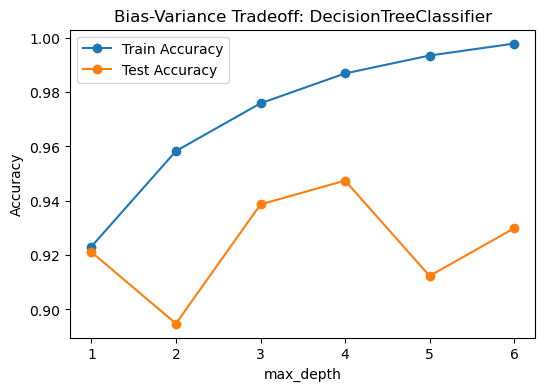

In [29]:
#Descision tree
bias_variance_tradeoff(DecisionTreeClassifier, 'max_depth', [1,2,3,4,5,6,None],
                       X_train, X_test, y_train, y_test)


In [25]:
def bias_variance_tradeoff_pipeline(model_func, param_name, param_range,
                                    X_train, X_test, y_train, y_test):
    train_scores = []
    test_scores = []

    for val in param_range:
        # Create the full model (pipeline) with the current hyperparameter
        model = model_func(val)
        
        model.fit(X_train, y_train)
        train_scores.append(model.score(X_train, y_train))
        test_scores.append(model.score(X_test, y_test))

    plt.figure(figsize=(6,4))
    plt.plot(param_range, train_scores, label='Train Accuracy', marker='o')
    plt.plot(param_range, test_scores, label='Test Accuracy', marker='o')
    plt.xlabel(param_name)
    plt.ylabel('Accuracy')
    plt.title(f'Bias-Variance Tradeoff')
    plt.legend()
    plt.show()


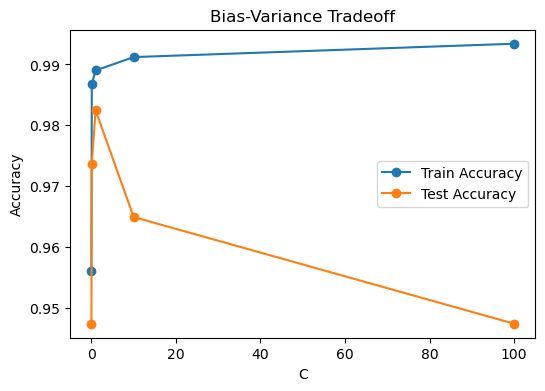

In [30]:
#Logistic regression
def logistic_pipeline(C_val):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(C=C_val, max_iter=5000))
    ])

bias_variance_tradeoff_pipeline(logistic_pipeline, "C", [0.01, 0.1, 1, 10, 100],
                                X_train, X_test, y_train, y_test)


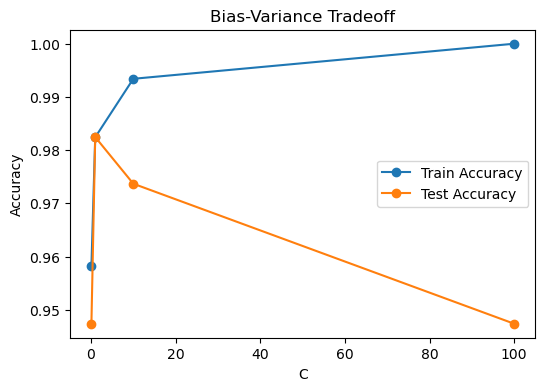

In [31]:
#SVM 
def svm_pipeline(C_val):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC(C=C_val, kernel='rbf'))
    ])

bias_variance_tradeoff_pipeline(svm_pipeline, "C", [0.1, 1, 10, 100],
                                X_train, X_test, y_train, y_test)
